# PCA (10 marks):

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA, PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn import metrics
import time
import matplotlib
import pandas as pd

In [2]:
# Load the fashion-MNIST dataset

import mnist_reader
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

(60000, 784)
(60000,)


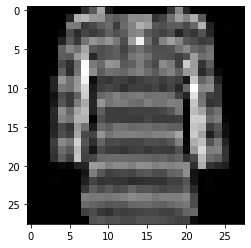

In [3]:
# Explore the dataset

print(X_train.shape)
print(y_train.shape)
index = np.random.randint(0, X_train.shape[0])
first_image = np.array(X_train[index], dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [4]:
def sort_evals_descending(evals, evectors):
    index = np.flip(np.argsort(evals))
    evals = evals[index]
    evectors = evectors[:, index]
    if evals.shape[0] == 2:
        if np.arccos(np.matmul(evectors[:, 0], 1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
            evectors[:, 0] = -evectors[:, 0]
        if np.arccos(np.matmul(evectors[:, 1], 1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
            evectors[:, 1] = -evectors[:, 1]
    return evals, evectors

In [5]:
def pca(X):
    X_bar = X - np.mean(X, axis=0)
    cov_matrix = 1 / X.shape[0] * np.matmul(X_bar.T, X_bar)
    evals, evectors = np.linalg.eigh(cov_matrix)
    evals, evectors = sort_evals_descending(evals, evectors)
    score = np.matmul(X, evectors)
    return score, evectors, evals

Text(0, 0.5, 'Second principal component')

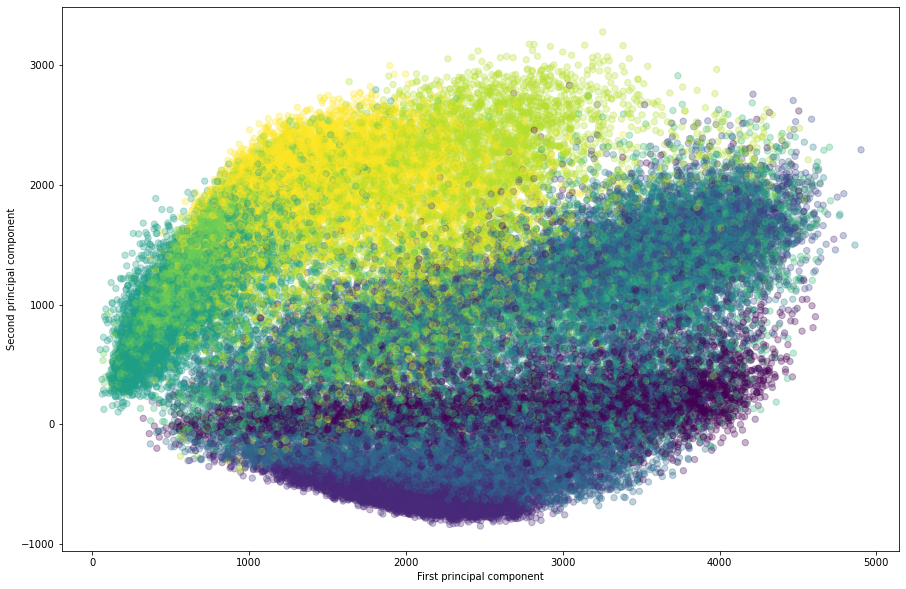

In [9]:
# Run PCA on the fashion-MNIST dataset

score, evectors, evals = pca(X_train)
first_two_features = score[:,:2]
plt.figure(figsize=(15,10))
plt.scatter(first_two_features[:, 0], first_two_features[:, 1], c=y_train, s=40, cmap='viridis', alpha=0.3)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

variance explained by first principle component: 0.2903922792136581
variance explained by second principle component: 0.1775530997816205
cumulated variance explained by two principle components: 0.46794537899527866


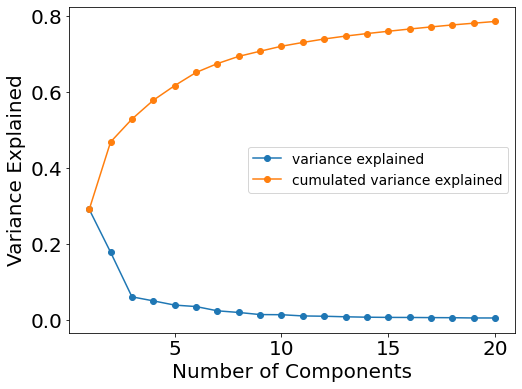

In [24]:
# Alternative method using SKLearn's PCA function and plotting scree plot

n = 20
pca = PCA(n_components=n)
rotatedData = pca.fit_transform(X_train)

var = pca.explained_variance_ratio_
var_explained = np.zeros(20)
for i in range(20):
    var_explained[i] = sum(var[:i+1])
    
print("variance explained by first principle component:", var[0])
print("variance explained by second principle component:", var[1])
print("cumulated variance explained by two principle components:", var_explained[1])
    
plt.figure(figsize = (8,6))
plt.plot(range(1, len(var_explained)+1), var, label="variance explained", marker="o")
plt.plot(range(1, len(var_explained)+1), var_explained, label="cumulated variance explained", marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.legend(fontsize="x-small")
plt.show()

# Gaussian mixture modelling (15 marks):

Use a Gaussian Mixture Model (GMM) to do (soft) clustering using the first two components from the PCA analysis. 
Make the GMM a mixture of 10 gaussians

Rand accuracy score: 0.8664062889937054
Time taken to produce model: 3.501300096511841


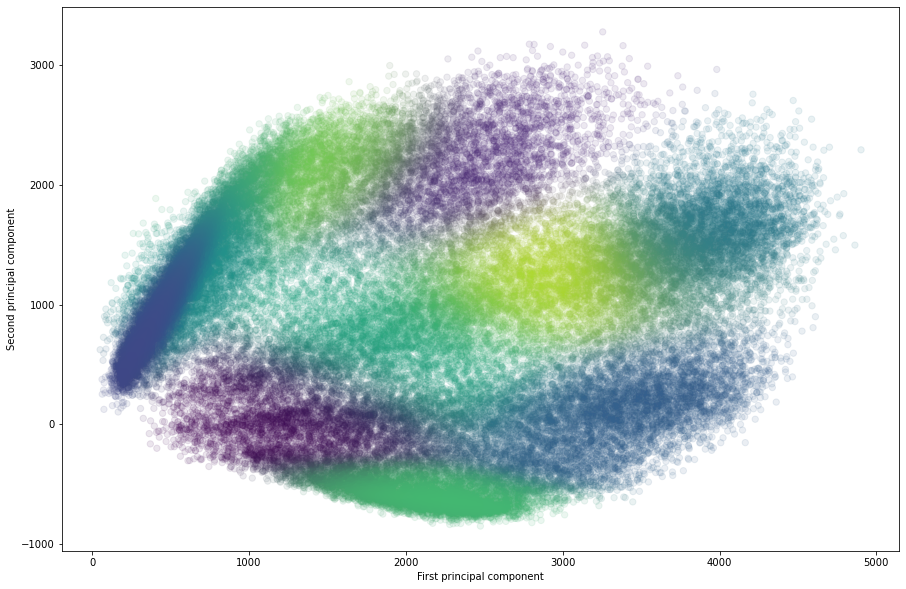

In [19]:
from matplotlib.colors import ListedColormap
from sklearn import mixture

colours = []
for i in range(0, 10):
    colours.append(matplotlib.cm.get_cmap('viridis')(i/10))

start = time.time()
model1 = mixture.GaussianMixture(n_components=10).fit(first_two_features)
probabilities = model1.predict_proba(first_two_features)
end = time.time()
plt.figure(figsize=(15,10))
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

pred = model1.predict(first_two_features)
print ("Rand accuracy score:", metrics.rand_score(pred, y_train))
print("Time taken to produce model:", end-start)

point_colours = []
for point_probs in probabilities:
    colour = point_probs @ colours
    a_index = len(colour)-1
    colour = colour[:a_index]
    point_colours.append(tuple(colour.tolist()))

plt.scatter(first_two_features[:, 0], first_two_features[:, 1], c=point_colours, s=40, cmap=ListedColormap(colours), alpha=0.1)


In [161]:
# Get true means of each class

d = {'class': y_train, 'pc1': first_two_features[:,0], 'pc2': first_two_features[:,1]}
df = pd.DataFrame(data=d)

mean = df[df['class'] == 1].mean()

classes = []
pc1means = []
pc2means = []
for i in range(9):
    classes.append(df[df['class'] == i].mean()[0])
    pc1means.append(df[df['class'] == i].mean()[1])
    pc2means.append(df[df['class'] == i].mean()[2])

In [178]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    Cov, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(Cov[1, 0], Cov[0, 0]))
    width, height = 2 * np.sqrt(s)
    for i in range(1, 4):
        ax.add_patch(Ellipse(position, i * width, i * height,angle, **kwargs))

def plot_gmm(gmm, X, ax=None):
    plt.figure(figsize=(15,10))
    plt.xlabel("First principal component")
    plt.ylabel("Second principal component")
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=point_colours, s=1, cmap='viridis', zorder=2, alpha=0.2)
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    ax.scatter(gmm.means_.T[0], gmm.means_.T[1], s=200, marker="P", color="black", alpha=1)
    ax.scatter(pc1means, pc2means, marker="X", s=200, alpha=1)

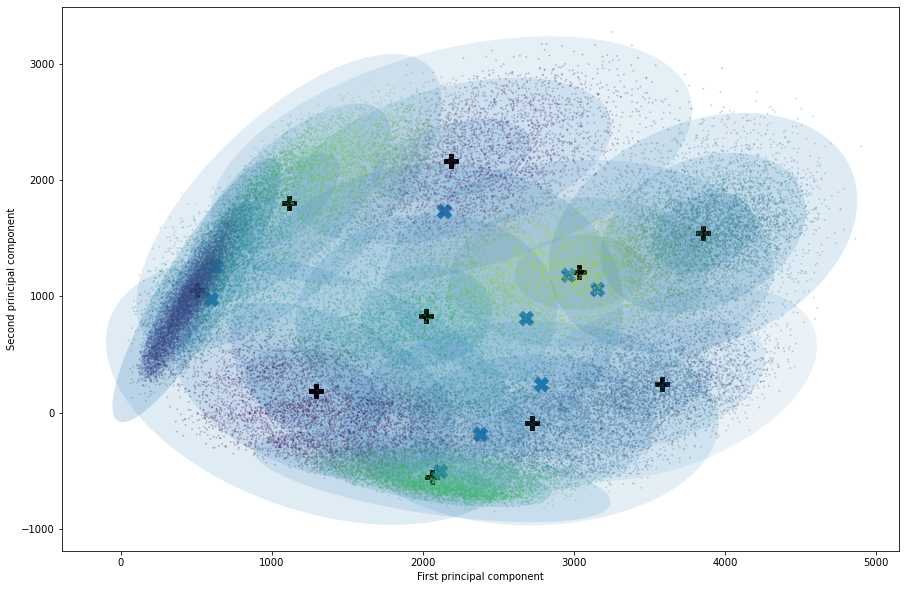

In [179]:
plot_gmm(model1, first_two_features)

In [ ]:
# GMM using all of the data

colours = []
for i in range(0, 10):
    colours.append(matplotlib.cm.get_cmap('viridis')(i/10))

start = time.time()
model = mixture.GaussianMixture(n_components=10, covariance_type='full').fit(X_train)
probabilities = model.predict_proba(X_train)
end = time.time()
plt.figure(figsize=(15,10))
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

pred = model.predict(X_test)
print ("Rand accuracy score: ", metrics.rand_score(pred, y_test))
print("Time taken to produce model:", end-start)

point_colours = []
for point_probs in probabilities:
    colour = point_probs @ colours
    a_index = len(colour)-1
    colour = colour[:a_index]
    point_colours.append(tuple(colour.tolist()))

plt.scatter(first_two_features[:, 0], first_two_features[:, 1], c=point_colours, s=40, cmap=ListedColormap(colours), alpha=0.1)

In [118]:
pred = model.predict(X_train)
print ("Accuracy score: ", metrics.adjusted_mutual_info_score(pred, y_train))

pred1 = model1.predict(first_two_features)
print ("Accuracy score: ", metrics.adjusted_mutual_info_score(pred1, y_train))

Rand accuracy score:  0.49517892394240914
Rand accuracy score:  0.44071048915603395
